In [1]:
from IPython.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [2]:
import os
import pickle
import matplotlib.image as mpimg
import numpy as np
import transformers
import sklearn.metrics
import tensorflow as tf
import tqdm.notebook as tqdm
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import os
import shutil

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Load ViT transformer model from huggingface: https://huggingface.co/google/vit-base-patch32-224-in21k

In [4]:
IMAGE_SIZE = 224
shutil.rmtree('test_dataset')
shutil.rmtree('train_dataset')
shutil.rmtree('valid_dataset')

In [5]:
backbone = transformers.TFViTModel.from_pretrained('google/vit-base-patch32-224-in21k')

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch32-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


# Dataset preparation

Write a function that transforms images in a folder (train, valid, test) and saves ViT outputs as a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). Remember that images are read with values in range `[0, 255]`, but ViT model exppects image values to be in range `[0, 1]`. In addition ViT model expects inputs to have the shape `[N, C, H, W]`, but dataset outputs images with shape `[N, H, W, C]`. Don't forget that transformers models return an object instead of just array of data, so you need to use `pooler_output` field from it.

In [6]:
def prepare_dataset(images_path: str, output_path: str, batch_size: int = 32, shuffle: bool = True) -> None:
    '''Reads images from `image_path`, computes ViT output on them and saves the output with labels to `output_path` as tf.data.Dataset
    
    Arguments:
        image_path: path to read images from,
        output_path: path to save dataset to,
        batch_size: batch_size to use for image processing,
        shuffle: 
    '''
    dataset = tf.keras.utils.image_dataset_from_directory(
        images_path,
        shuffle=shuffle,
        image_size=(224, 224),
        batch_size=batch_size
    )
    
    X, y = [], []
    
    for images, labels in tqdm.tqdm(dataset):
        images = images / 255
        images = tf.transpose(images, [0, 3, 1, 2])
        X.append(backbone.predict(images, verbose=0).pooler_output)
        y.append(labels)
    X = tf.concat(X, axis=0)
    y = tf.concat(y, axis=0)
    X_dataset = tf.data.Dataset.from_tensor_slices(X)
    y_dataset = tf.data.Dataset.from_tensor_slices(y)
    
    tf.data.Dataset.zip((X_dataset, y_dataset)).save(output_path)

Since images never change, we only need to compute ViT output on them once per image. Doing so before the actual model training increases training speed

In [7]:
prepare_dataset('train', 'train_dataset')
prepare_dataset('valid', 'valid_dataset', shuffle=False)
prepare_dataset('test',  'test_dataset',  shuffle=False)

Found 1122 files belonging to 13 classes.


  0%|          | 0/36 [00:00<?, ?it/s]

Found 269 files belonging to 13 classes.


  0%|          | 0/9 [00:00<?, ?it/s]

Found 743 files belonging to 12 classes.


  0%|          | 0/24 [00:00<?, ?it/s]

In [8]:
train_dataset = tf.data.Dataset.load('train_dataset')
valid_dataset = tf.data.Dataset.load('valid_dataset')
test_dataset  = tf.data.Dataset.load('test_dataset')

In [9]:
print(f'Number of train images: {len(train_dataset)}; Number of validation images: {len(valid_dataset)}; Number of test images: {len(test_dataset)}')

Number of train images: 1122; Number of validation images: 269; Number of test images: 743


Note the structure of the dataset. Each element is a pair: embedding vector of size 768 and a single class label

In [10]:
train_dataset.element_spec

(TensorSpec(shape=(768,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

# Build classification model

In [11]:
# classes = pickle.load(open('classes.bin', 'rb'))

tf.keras models are built as a graph, see more [here](https://www.tensorflow.org/guide/keras/functional).

First, make an input layer that accepts a vector of type tf.float32 and size 768.

In [12]:
inputs = tf.keras.layers.Input(shape=(768,), dtype=tf.float32,  name='vit_embeddings')

In [13]:
# len(classes)

Add at least one Dense layer, not that the size of the last vector must be equal to the number of classes and have a `softmax` activation

In [14]:
x = tf.keras.layers.Dense(units=450, activation='softmax')(inputs)

Finish constructing the model

In [15]:
model = tf.keras.models.Model(inputs=inputs, outputs=x, name='odnoklassniki_classifictaion_model')

In [16]:
model.summary()

Model: "odnoklassniki_classifictaion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit_embeddings (InputLayer)  [(None, 768)]            0         
                                                                 
 dense (Dense)               (None, 450)               346050    
                                                                 
Total params: 346,050
Trainable params: 346,050
Non-trainable params: 0
_________________________________________________________________


Compile the model. The loss is categorical crossentropy that expects ground truth to be class labels (sparse) rather than one hot vectors. Loss is [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam). The only metric is [Accuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy).

In [17]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

[Prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) and [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) the datasets.

In [18]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset  = test_dataset.prefetch(tf.data.AUTOTUNE)

In [19]:
BATCH_SIZE = 64

In [20]:
train_dataset = train_dataset.batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)
test_dataset  = test_dataset.batch(BATCH_SIZE)

Note the structure of the dataset. Each element is a pair of batched tensors: batch of embedding vectors of size 768 and a batch of class labels

In [21]:
train_dataset.element_spec

(TensorSpec(shape=(None, 768), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Prepare a [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save the best model while training

In [22]:
MODEL_PATH = 'trained_model'

In [23]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(MODEL_PATH, save_best_only=True)]

Train the model

In [24]:
EPOCHS = 100

In [25]:
model.fit(train_dataset, validation_data=valid_dataset, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
14/18 [======================>.......] - ETA: 0s - loss: 4.2214 - accuracy: 0.2109    

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 1s 38ms/step - loss: 3.8471 - accuracy: 0.2790 - val_loss: 2.2005 - val_accuracy: 0.5576
Epoch 2/100
12/18 [===================>..........] - ETA: 0s - loss: 1.8086 - accuracy: 0.7422

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 23ms/step - loss: 1.6886 - accuracy: 0.7834 - val_loss: 1.4480 - val_accuracy: 0.8067
Epoch 3/100
13/18 [====================>.........] - ETA: 0s - loss: 1.1439 - accuracy: 0.9339

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 1.0933 - accuracy: 0.9385 - val_loss: 1.0390 - val_accuracy: 0.8885
Epoch 4/100
12/18 [===================>..........] - ETA: 0s - loss: 0.8003 - accuracy: 0.9635

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.7635 - accuracy: 0.9661 - val_loss: 0.7973 - val_accuracy: 0.9257
Epoch 5/100
13/18 [====================>.........] - ETA: 0s - loss: 0.5844 - accuracy: 0.9736

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 0.5676 - accuracy: 0.9750 - val_loss: 0.6422 - val_accuracy: 0.9405
Epoch 6/100
11/18 [=================>............] - ETA: 0s - loss: 0.4599 - accuracy: 0.9815

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 21ms/step - loss: 0.4432 - accuracy: 0.9822 - val_loss: 0.5355 - val_accuracy: 0.9517
Epoch 7/100
12/18 [===================>..........] - ETA: 0s - loss: 0.3690 - accuracy: 0.9870

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 22ms/step - loss: 0.3585 - accuracy: 0.9848 - val_loss: 0.4590 - val_accuracy: 0.9554
Epoch 8/100
11/18 [=================>............] - ETA: 0s - loss: 0.3067 - accuracy: 0.9872

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.2978 - accuracy: 0.9866 - val_loss: 0.4019 - val_accuracy: 0.9591
Epoch 9/100
12/18 [===================>..........] - ETA: 0s - loss: 0.2586 - accuracy: 0.9896

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.2525 - accuracy: 0.9884 - val_loss: 0.3579 - val_accuracy: 0.9628
Epoch 10/100
11/18 [=================>............] - ETA: 0s - loss: 0.2233 - accuracy: 0.9901

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.2177 - accuracy: 0.9902 - val_loss: 0.3233 - val_accuracy: 0.9628
Epoch 11/100
12/18 [===================>..........] - ETA: 0s - loss: 0.1943 - accuracy: 0.9922

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 0.1903 - accuracy: 0.9911 - val_loss: 0.2954 - val_accuracy: 0.9628
Epoch 12/100
11/18 [=================>............] - ETA: 0s - loss: 0.1720 - accuracy: 0.9929

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.1681 - accuracy: 0.9920 - val_loss: 0.2725 - val_accuracy: 0.9628
Epoch 13/100
10/18 [===============>..............] - ETA: 0s - loss: 0.1541 - accuracy: 0.9937

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 28ms/step - loss: 0.1500 - accuracy: 0.9929 - val_loss: 0.2534 - val_accuracy: 0.9628
Epoch 14/100
11/18 [=================>............] - ETA: 0s - loss: 0.1377 - accuracy: 0.9957

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 0.1348 - accuracy: 0.9947 - val_loss: 0.2373 - val_accuracy: 0.9628
Epoch 15/100
11/18 [=================>............] - ETA: 0s - loss: 0.1245 - accuracy: 0.9957

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 0.1221 - accuracy: 0.9955 - val_loss: 0.2236 - val_accuracy: 0.9665
Epoch 16/100
12/18 [===================>..........] - ETA: 0s - loss: 0.1132 - accuracy: 0.9961

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 28ms/step - loss: 0.1111 - accuracy: 0.9955 - val_loss: 0.2117 - val_accuracy: 0.9665
Epoch 17/100
11/18 [=================>............] - ETA: 0s - loss: 0.1037 - accuracy: 0.9972

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.1017 - accuracy: 0.9964 - val_loss: 0.2014 - val_accuracy: 0.9665
Epoch 18/100
10/18 [===============>..............] - ETA: 0s - loss: 0.0961 - accuracy: 0.9969

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 1s 38ms/step - loss: 0.0935 - accuracy: 0.9973 - val_loss: 0.1924 - val_accuracy: 0.9665
Epoch 19/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0880 - accuracy: 0.9987

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.0863 - accuracy: 0.9982 - val_loss: 0.1844 - val_accuracy: 0.9665
Epoch 20/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0816 - accuracy: 0.9987

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 28ms/step - loss: 0.0800 - accuracy: 0.9982 - val_loss: 0.1773 - val_accuracy: 0.9628
Epoch 21/100
11/18 [=================>............] - ETA: 0s - loss: 0.0759 - accuracy: 0.9986

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.0743 - accuracy: 0.9991 - val_loss: 0.1710 - val_accuracy: 0.9628
Epoch 22/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0708 - accuracy: 0.9987

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.0693 - accuracy: 0.9991 - val_loss: 0.1653 - val_accuracy: 0.9628
Epoch 23/100
11/18 [=================>............] - ETA: 0s - loss: 0.0662 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 0.0648 - accuracy: 1.0000 - val_loss: 0.1601 - val_accuracy: 0.9628
Epoch 24/100
11/18 [=================>............] - ETA: 0s - loss: 0.0621 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 27ms/step - loss: 0.0607 - accuracy: 1.0000 - val_loss: 0.1554 - val_accuracy: 0.9628
Epoch 25/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0585 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.0570 - accuracy: 1.0000 - val_loss: 0.1512 - val_accuracy: 0.9628
Epoch 26/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0551 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.0537 - accuracy: 1.0000 - val_loss: 0.1473 - val_accuracy: 0.9628
Epoch 27/100
13/18 [====================>.........] - ETA: 0s - loss: 0.0518 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 22ms/step - loss: 0.0507 - accuracy: 1.0000 - val_loss: 0.1437 - val_accuracy: 0.9628
Epoch 28/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0492 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.0479 - accuracy: 1.0000 - val_loss: 0.1404 - val_accuracy: 0.9628
Epoch 29/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0466 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 0.0453 - accuracy: 1.0000 - val_loss: 0.1374 - val_accuracy: 0.9628
Epoch 30/100
11/18 [=================>............] - ETA: 0s - loss: 0.0442 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 23ms/step - loss: 0.0430 - accuracy: 1.0000 - val_loss: 0.1346 - val_accuracy: 0.9628
Epoch 31/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0421 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.0409 - accuracy: 1.0000 - val_loss: 0.1320 - val_accuracy: 0.9628
Epoch 32/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0401 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 23ms/step - loss: 0.0389 - accuracy: 1.0000 - val_loss: 0.1296 - val_accuracy: 0.9628
Epoch 33/100
11/18 [=================>............] - ETA: 0s - loss: 0.0381 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.0370 - accuracy: 1.0000 - val_loss: 0.1273 - val_accuracy: 0.9628
Epoch 34/100
13/18 [====================>.........] - ETA: 0s - loss: 0.0363 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.0353 - accuracy: 1.0000 - val_loss: 0.1252 - val_accuracy: 0.9628
Epoch 35/100
11/18 [=================>............] - ETA: 0s - loss: 0.0348 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.0337 - accuracy: 1.0000 - val_loss: 0.1233 - val_accuracy: 0.9628
Epoch 36/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0334 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 27ms/step - loss: 0.0323 - accuracy: 1.0000 - val_loss: 0.1214 - val_accuracy: 0.9628
Epoch 37/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0320 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.0309 - accuracy: 1.0000 - val_loss: 0.1197 - val_accuracy: 0.9628
Epoch 38/100
11/18 [=================>............] - ETA: 0s - loss: 0.0306 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 27ms/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.1181 - val_accuracy: 0.9628
Epoch 39/100
11/18 [=================>............] - ETA: 0s - loss: 0.0293 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.0284 - accuracy: 1.0000 - val_loss: 0.1166 - val_accuracy: 0.9628
Epoch 40/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0283 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 0.0273 - accuracy: 1.0000 - val_loss: 0.1151 - val_accuracy: 0.9628
Epoch 41/100
11/18 [=================>............] - ETA: 0s - loss: 0.0271 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 0.0262 - accuracy: 1.0000 - val_loss: 0.1138 - val_accuracy: 0.9628
Epoch 42/100
11/18 [=================>............] - ETA: 0s - loss: 0.0261 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 0.0252 - accuracy: 1.0000 - val_loss: 0.1125 - val_accuracy: 0.9628
Epoch 43/100
11/18 [=================>............] - ETA: 0s - loss: 0.0251 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 1s 39ms/step - loss: 0.0243 - accuracy: 1.0000 - val_loss: 0.1113 - val_accuracy: 0.9628
Epoch 44/100
11/18 [=================>............] - ETA: 0s - loss: 0.0242 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 27ms/step - loss: 0.0234 - accuracy: 1.0000 - val_loss: 0.1101 - val_accuracy: 0.9628
Epoch 45/100
11/18 [=================>............] - ETA: 0s - loss: 0.0234 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.0226 - accuracy: 1.0000 - val_loss: 0.1090 - val_accuracy: 0.9628
Epoch 46/100
11/18 [=================>............] - ETA: 0s - loss: 0.0226 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 0.0218 - accuracy: 1.0000 - val_loss: 0.1080 - val_accuracy: 0.9628
Epoch 47/100
11/18 [=================>............] - ETA: 0s - loss: 0.0218 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.0211 - accuracy: 1.0000 - val_loss: 0.1070 - val_accuracy: 0.9628
Epoch 48/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0212 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 0.0203 - accuracy: 1.0000 - val_loss: 0.1061 - val_accuracy: 0.9628
Epoch 49/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0205 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.0197 - accuracy: 1.0000 - val_loss: 0.1052 - val_accuracy: 0.9628
Epoch 50/100
11/18 [=================>............] - ETA: 0s - loss: 0.0197 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.0190 - accuracy: 1.0000 - val_loss: 0.1043 - val_accuracy: 0.9628
Epoch 51/100
11/18 [=================>............] - ETA: 0s - loss: 0.0191 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 23ms/step - loss: 0.0184 - accuracy: 1.0000 - val_loss: 0.1035 - val_accuracy: 0.9628
Epoch 52/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0186 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.1028 - val_accuracy: 0.9628
Epoch 53/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0180 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.1020 - val_accuracy: 0.9628
Epoch 54/100
13/18 [====================>.........] - ETA: 0s - loss: 0.0173 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.0168 - accuracy: 1.0000 - val_loss: 0.1013 - val_accuracy: 0.9628
Epoch 55/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0170 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 23ms/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 0.1007 - val_accuracy: 0.9628
Epoch 56/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0165 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 28ms/step - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.1000 - val_accuracy: 0.9628
Epoch 57/100
10/18 [===============>..............] - ETA: 0s - loss: 0.0162 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.0994 - val_accuracy: 0.9628
Epoch 58/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0156 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 27ms/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 0.0988 - val_accuracy: 0.9628
Epoch 59/100
11/18 [=================>............] - ETA: 0s - loss: 0.0151 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.0982 - val_accuracy: 0.9628
Epoch 60/100
11/18 [=================>............] - ETA: 0s - loss: 0.0146 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 27ms/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 0.0977 - val_accuracy: 0.9628
Epoch 61/100
11/18 [=================>............] - ETA: 0s - loss: 0.0143 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.0972 - val_accuracy: 0.9628
Epoch 62/100
11/18 [=================>............] - ETA: 0s - loss: 0.0139 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 0.0967 - val_accuracy: 0.9628
Epoch 63/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0136 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.0962 - val_accuracy: 0.9628
Epoch 64/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0132 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.0957 - val_accuracy: 0.9628
Epoch 65/100
11/18 [=================>............] - ETA: 0s - loss: 0.0128 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 27ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.0953 - val_accuracy: 0.9628
Epoch 66/100
11/18 [=================>............] - ETA: 0s - loss: 0.0125 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.0948 - val_accuracy: 0.9628
Epoch 67/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0123 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 0.0944 - val_accuracy: 0.9628
Epoch 68/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0120 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 1s 43ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.0940 - val_accuracy: 0.9628
Epoch 69/100
13/18 [====================>.........] - ETA: 0s - loss: 0.0116 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 27ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.0936 - val_accuracy: 0.9665
Epoch 70/100
11/18 [=================>............] - ETA: 0s - loss: 0.0113 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 1s 30ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.0933 - val_accuracy: 0.9665
Epoch 71/100
11/18 [=================>............] - ETA: 0s - loss: 0.0111 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0929 - val_accuracy: 0.9665
Epoch 72/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0109 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.0926 - val_accuracy: 0.9665
Epoch 73/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0106 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 25ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0922 - val_accuracy: 0.9665
Epoch 74/100
11/18 [=================>............] - ETA: 0s - loss: 0.0103 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 26ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.0919 - val_accuracy: 0.9665
Epoch 75/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0101 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 1s 29ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.0916 - val_accuracy: 0.9703
Epoch 76/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0099 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 23ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0913 - val_accuracy: 0.9703
Epoch 77/100
13/18 [====================>.........] - ETA: 0s - loss: 0.0096 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.0910 - val_accuracy: 0.9703
Epoch 78/100
11/18 [=================>............] - ETA: 0s - loss: 0.0094 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 23ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.0907 - val_accuracy: 0.9703
Epoch 79/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0093 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 22ms/step - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0905 - val_accuracy: 0.9703
Epoch 80/100
13/18 [====================>.........] - ETA: 0s - loss: 0.0090 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.0902 - val_accuracy: 0.9703
Epoch 81/100
14/18 [======================>.......] - ETA: 0s - loss: 0.0087 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 23ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0899 - val_accuracy: 0.9703
Epoch 82/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0087 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 23ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0897 - val_accuracy: 0.9703
Epoch 83/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0085 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0895 - val_accuracy: 0.9703
Epoch 84/100
13/18 [====================>.........] - ETA: 0s - loss: 0.0083 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 23ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0892 - val_accuracy: 0.9703
Epoch 85/100
13/18 [====================>.........] - ETA: 0s - loss: 0.0081 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 22ms/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0890 - val_accuracy: 0.9703
Epoch 86/100
13/18 [====================>.........] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0888 - val_accuracy: 0.9703
Epoch 87/100
13/18 [====================>.........] - ETA: 0s - loss: 0.0078 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 23ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.0886 - val_accuracy: 0.9703
Epoch 88/100
14/18 [======================>.......] - ETA: 0s - loss: 0.0075 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 22ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0884 - val_accuracy: 0.9703
Epoch 89/100
13/18 [====================>.........] - ETA: 0s - loss: 0.0075 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 22ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0882 - val_accuracy: 0.9703
Epoch 90/100
13/18 [====================>.........] - ETA: 0s - loss: 0.0073 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0880 - val_accuracy: 0.9703
Epoch 91/100
13/18 [====================>.........] - ETA: 0s - loss: 0.0072 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 23ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0878 - val_accuracy: 0.9703
Epoch 92/100
14/18 [======================>.......] - ETA: 0s - loss: 0.0069 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 21ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0876 - val_accuracy: 0.9703
Epoch 93/100
13/18 [====================>.........] - ETA: 0s - loss: 0.0069 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 1s 35ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0875 - val_accuracy: 0.9703
Epoch 94/100
13/18 [====================>.........] - ETA: 0s - loss: 0.0068 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 23ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0873 - val_accuracy: 0.9703
Epoch 95/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0067 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 23ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0871 - val_accuracy: 0.9703
Epoch 96/100
13/18 [====================>.........] - ETA: 0s - loss: 0.0065 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 22ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.0870 - val_accuracy: 0.9703
Epoch 97/100
12/18 [===================>..........] - ETA: 0s - loss: 0.0065 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 23ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0868 - val_accuracy: 0.9703
Epoch 98/100
14/18 [======================>.......] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 24ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0867 - val_accuracy: 0.9703
Epoch 99/100
14/18 [======================>.......] - ETA: 0s - loss: 0.0061 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 22ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0865 - val_accuracy: 0.9703
Epoch 100/100
14/18 [======================>.......] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000

INFO:tensorflow:Assets written to: trained_model\assets


INFO:tensorflow:Assets written to: trained_model\assets


18/18 [==============================] - 0s 21ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0864 - val_accuracy: 0.9703


Evaluate model on the test dataset

In [26]:
model.evaluate(x=test_dataset)

12/12 [==============================] - 0s 2ms/step - loss: 9.8544 - accuracy: 0.0000e+00


[9.85436725616455, 0.0]

Plot confusion matrix on combined valid and test dataset using [ConfusionMatrixDisplay.from_predictions](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions)

In [27]:
combined_dataset = valid_dataset.concatenate(test_dataset)

In [28]:
y_pred = np.argmax(model.predict(combined_dataset), axis=-1)

17/17 [==============================] - 0s 2ms/step


In [29]:
y_true = np.concatenate([i[1] for i in combined_dataset])

The resulting image is VERY LARGY so drawing takes a significant amount of time

In [30]:
# _, ax = plt.subplots(figsize=(150, 150))
# sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, colorbar=False)
# plt.savefig('confusion_matrix.png')
# plt.show()

# Testing on images from the internet

First, make a function that reads an image from disk, resizes and normalizes it. You're only allowed to use tensorflow functions

In [31]:
model = tf.keras.models.load_model('trained_model')

In [32]:
def read_image(path: str) -> tf.Tensor:
    '''Reads image to tf.Tensor
    
    Arguments:
        path: path to read image from
        
    Returns:
        tf.Tensor with shape [H, W, C] and values in range [0, 1]
    
    '''
    img = tf.keras.utils.load_img(path)
    input_arr = tf.keras.utils.img_to_array(img)
    input_arr = input_arr/255
    input_arr = tf.image.resize(input_arr, [224, 224])
    input_arr = tf.convert_to_tensor(input_arr, dtype=tf.float32)
    return input_arr

/# LOAD MODEL FROM DISK

In [33]:
# model.load_weights('weights.h5')

In [34]:
classes = os.listdir('train/')
classes

['Arhip Nikolaev',
 'Arkadii Kasper',
 'Asia Alexeeva',
 'Damir Magomedov',
 'Dasha Sorokina',
 'Edik Sushkov',
 'Gleb Karitskii',
 'Ivan Beliaev',
 'Kirill Sannikov',
 'Matvei Beliaev',
 'Minsu',
 'Vlad Peleganchuk',
 'Vova Titkov']

Now make a new model that combines ViT model and the one you just trained. This time your model expects an image tensor of shape `[H, W, C]` and type `tf.float32`. The values `H, W, C` must be replaced with actual values depending on the size of input images

In [35]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='image_input')

Transpose image to fit requirements

In [36]:
x = tf.keras.layers.Lambda(lambda x: tf.transpose(x, [0, 3, 1, 2]), name='transpose')(inputs)

Get output from ViT model, remember `pooler_output`

In [37]:
x = backbone(x).pooler_output

Get output from the model you trained

In [38]:
x = model(x)

Make evaluation model

In [39]:
evaluation_model = tf.keras.models.Model(inputs=inputs, outputs=x, name='evaluation_model')

Make a function that accepts a path to some image, predicts model output on it and displays image with predicted class caption and probability. Don't forget to use `predict` function and remember that model expects batched input, so data passed to model must be of shape `[1, H, W, C]`

In [40]:
def get_image_class(path: str, ax) -> None:
    '''Gets model output for image specified by `path` and plots the result.
    
    Arguments:
        path: path to image to be tested
    '''
    ax.axis('off')
    image = read_image(path)
    image = tf.expand_dims(image, axis=0)
    pred = evaluation_model.predict(image)
    img = plt.imread(path)
    ax.imshow(img)
    ax.set_title(f'{classes[pred[0].argmax()]} - {pred[0].max()*100}%')

In [41]:
%matplotlib inline

1/1 [==============================] - 2s 2s/step


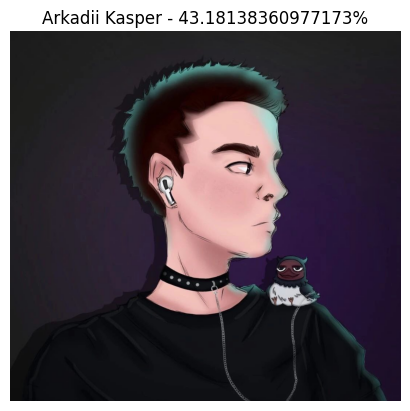

In [42]:
get_image_class('6.jpg', plt.gca())

1/1 [==============================] - 0s 117ms/step


FileNotFoundError: [Errno 2] No such file or directory: '13.jpg'

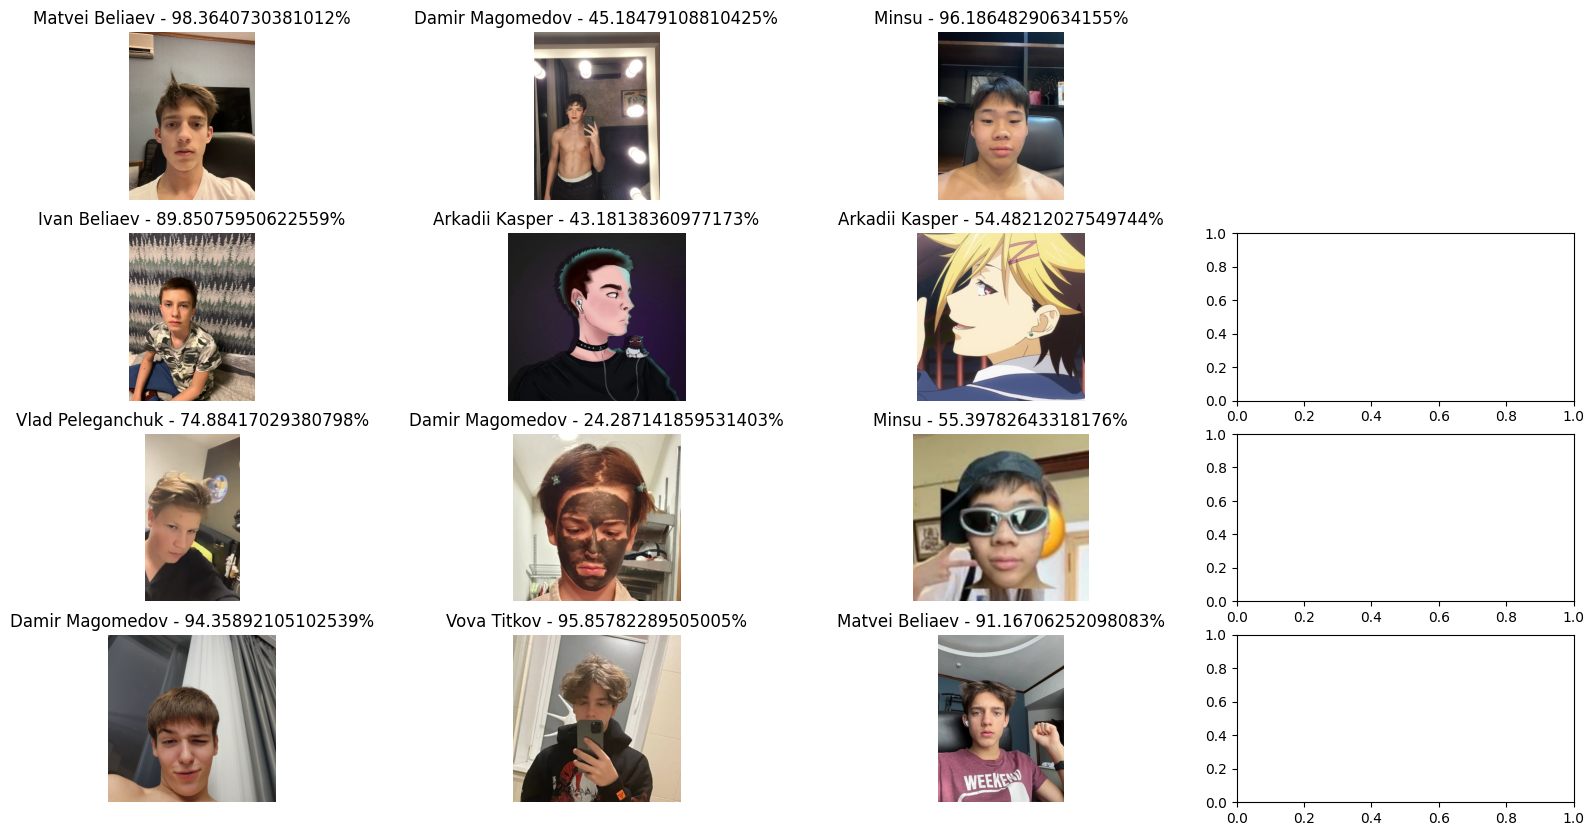

In [43]:
_, ax = plt.subplots(ncols=4, nrows=4, figsize=(20, 10))
n = 1
for i in range(4):
    for g in range(4):
        get_image_class(f'{n}.jpg', ax[g][i])
        n+=1